# DiploDatos 2019 - Análisis de Series Temporales

## Integrantes

| Nombre | e-mail |
|------|------|
|Rivadero, Isabel | isarivadero@hotmail.com |
|Vargas, Miguel | lvc0107@protonmail.com |
|Mancuso, Fernando | manquius@gmail.com |

## Práctico de Introducción al aprendizaje automático

En este práctico no introduciremos en las primeras herramientas de aprendizaje
automático. Diseñaremos e implementaremos algunos modelos simples y definir métricas
para ver como performan.

### Dataset

In [1]:
### Aumentar el ancho del notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
sb.set(rc={'figure.figsize':(10,6)})

cols = ['service',
        'sender_zipcode',
        'receiver_zipcode',
        'sender_state',
        'receiver_state',
        'shipment_type',
        'quantity',
        'status',
        'date_created',
        'date_sent',
        'date_visit',
        'target']
cols_holidays = ['holiday', 
                 'description']
data_path = './shipments_BR_201903.csv'
holidays = './holidays.csv'

#### Referencia de las columnas
* **service**: Identificador unico que corresponde a un tipo de servicio de un correo en particular.
* **sender_zipcode:** Código postal de quien envía el paquete (usualmente el vendedor).
* **receiver_zipcode:** Código postal de quien recibe el paquete (usualmente el comprador).
* **sender_state:** Nombre abreviado del estado de quien envía el paquete.
* **receiver_state:** Nombre abreviado del estado de quien recibe el paquete.
* **quantity:** Cantidad de items que tiene dentro el paquete.
* **status:** Estado final del envío.
* **date_created:** Fecha de compra de el o los items.
* **date_sent:** Fecha en que el correo recibe el paquete.
* **date_visit:** Fecha en que el correo entrega el paquete.
* **target:** Cantidad de dias hábiles que tardó el correo en entregar el paquete desde que lo recibe.


In [3]:
df = pd.read_csv(data_path, usecols=cols)
df.shape

(1000000, 12)

In [4]:
df.head()

,sender_state,sender_zipcode,receiver_state,receiver_zipcode,shipment_type,quantity,service,status,date_created,date_sent,date_visit,target
0,SP,3005,SP,5409,express,1,0,done,2019-03-04 00:00:00,2019-03-05 13:24:00,2019-03-07 18:01:00,2
1,SP,17052,MG,37750,standard,1,1,done,2019-03-19 00:00:00,2019-03-20 14:44:00,2019-03-27 10:21:00,5
2,SP,2033,SP,11040,express,1,0,done,2019-02-18 00:00:00,2019-02-21 15:08:00,2019-02-28 18:19:00,5
3,SP,13900,SP,18500,express,1,0,done,2019-03-09 00:00:00,2019-03-11 15:48:00,2019-03-12 13:33:00,1
4,SP,4361,RS,96810,express,1,0,done,2019-03-08 00:00:00,2019-03-12 08:19:00,2019-03-16 08:24:00,4


In [5]:
# set seed for reproducibility
np.random.seed(0)

**Eliminamos datos inconsistentes:**

Aplicamos curacion y limpieza de datos

In [6]:
df_clean = df[(df['date_sent'] <= df['date_visit']) & (df['date_created'] <= df['date_sent']) & (df['date_created'] <= df['date_visit'])].copy()
df.shape

(1000000, 12)

**Removemos outliers.**

In [7]:
df_clean = df_clean[df_clean['target'] < 23].copy()
df_clean.shape

(990370, 12)

In [8]:
df.sample(5)

,sender_state,sender_zipcode,receiver_state,receiver_zipcode,shipment_type,quantity,service,status,date_created,date_sent,date_visit,target
157105,SP,14405,MG,37706,standard,2,3,done,2019-03-13 00:00:00,2019-03-19 20:52:00,2019-03-22 11:00:00,3
374554,BA,40260,SE,49088,standard,1,1,done,2019-03-04 00:00:00,2019-03-06 15:32:00,2019-03-23 11:23:00,12
688694,SP,8061,DF,70236,express,1,0,done,2019-03-15 00:00:00,2019-03-15 16:04:00,2019-03-18 12:00:00,1
265381,SP,3118,BA,48455,standard,3,1,done,2019-03-10 00:00:00,2019-03-11 14:58:00,2019-03-27 07:56:00,12
955415,SP,14402,DF,71503,standard,1,4,done,2019-03-01 00:00:00,2019-03-07 03:55:36,2019-03-11 16:39:00,1


In [9]:
df.dtypes

sender_state        object
sender_zipcode       int64
receiver_state      object
receiver_zipcode     int64
shipment_type       object
quantity             int64
service              int64
status              object
date_created        object
date_sent           object
date_visit          object
target               int64
dtype: object

In [10]:
df.describe()

,sender_zipcode,receiver_zipcode,quantity,service,target
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,22637.975896,41650.306365,1.277814,1.182677,6.021577
std,27817.028435,30952.352631,0.661583,1.486557,5.157973
min,1001.000000,1001.000000,1.000000,0.000000,0.000000
25%,4836.000000,13465.000000,1.000000,0.000000,2.000000
50%,12091.000000,35164.000000,1.000000,1.000000,4.000000
75%,23050.000000,72308.000000,1.000000,1.000000,9.000000
max,99990.000000,99990.000000,5.000000,11.000000,118.000000


####  Implementación
Solo vamos a diferenciar dos tipos de envíos:
​ rápidos: un envío es rápido si llega antes de 3 días hábiles 
​ y lentos: si llega después de 3 días hábiles.
Esto nos reduce los problemas de clasificación a solo 2 clases.


#### Definiciones básicas:
1- Definir una métrica binaria para evaluar los modelos



#### En esta metrica faltaria ver como asegurar que los unos y los ceros del real y del calculado representan lo mismo

In [11]:
# defino una metrica
def metrica(calculado, real):
    cont = 0
    for i in range(len(real)):
        if (calculado[i] == real[i]):
            cont +=1
    
    return cont/len(real)

2- Diseñar un modelo -baseline- para los envíos de SP a SP, como el modelo más
simple posible. Para esto no necesitamos machine learning, solo proponer una
heurística a partir de los datos observados en los prácticos de análisis


In [12]:
sp_sp = df_clean[(df_clean['sender_state'] == 'SP') & (df_clean['receiver_state'] == 'SP')]
sp_sp.head()

,sender_state,sender_zipcode,receiver_state,receiver_zipcode,shipment_type,quantity,service,status,date_created,date_sent,date_visit,target
0,SP,3005,SP,5409,express,1,0,done,2019-03-04 00:00:00,2019-03-05 13:24:00,2019-03-07 18:01:00,2
2,SP,2033,SP,11040,express,1,0,done,2019-02-18 00:00:00,2019-02-21 15:08:00,2019-02-28 18:19:00,5
3,SP,13900,SP,18500,express,1,0,done,2019-03-09 00:00:00,2019-03-11 15:48:00,2019-03-12 13:33:00,1
8,SP,2313,SP,4165,express,2,0,done,2019-02-28 00:00:00,2019-03-01 14:35:00,2019-03-04 14:22:00,1
10,SP,11015,SP,15025,express,2,3,done,2019-02-24 00:00:00,2019-03-04 23:54:00,2019-03-11 22:00:00,4


In [13]:
sp_sp.shape

(278081, 12)

In [14]:
# but it couldnt be useful for you depending on your approach)
from sklearn.model_selection import train_test_split


# División entre instancias y etiquetas
X = sp_sp.drop('target', axis=1)
y = sp_sp['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
X_train.head()

,sender_state,sender_zipcode,receiver_state,receiver_zipcode,shipment_type,quantity,service,status,date_created,date_sent,date_visit
776089,SP,18010,SP,5712,express,1,0,done,2019-03-19 00:00:00,2019-03-20 17:03:00,2019-03-22 12:05:00
383341,SP,18150,SP,6775,standard,2,1,done,2019-03-06 00:00:00,2019-03-07 14:17:00,2019-03-16 10:35:00
893527,SP,6422,SP,16290,express,1,0,done,2019-03-11 00:00:00,2019-03-13 00:09:27,2019-03-18 15:41:00
746617,SP,6622,SP,11740,standard,1,1,done,2019-03-04 00:00:00,2019-03-06 10:53:00,2019-03-12 12:32:00
696614,SP,13324,SP,5763,express,1,0,done,2019-03-24 00:00:00,2019-03-25 14:37:00,2019-03-26 18:42:00


In [16]:
X_train.shape

(222464, 11)

In [17]:
y_train.head()

776089    2
383341    6
893527    3
746617    3
696614    1
Name: target, dtype: int64

In [18]:
y_train.shape

(222464,)

In [19]:
X_test.head()

,sender_state,sender_zipcode,receiver_state,receiver_zipcode,shipment_type,quantity,service,status,date_created,date_sent,date_visit
68262,SP,15800,SP,13304,express,1,0,done,2019-03-04 00:00:00,2019-03-07 19:15:30,2019-03-11 17:36:00
269933,SP,12232,SP,12237,express,1,0,done,2019-03-07 00:00:00,2019-03-08 15:40:00,2019-03-11 12:40:00
206944,SP,1009,SP,6852,express,1,0,done,2019-02-24 00:00:00,2019-02-25 11:13:00,2019-03-06 12:40:00
422707,SP,9890,SP,13974,standard,1,3,done,2019-03-04 00:00:00,2019-03-07 04:32:00,2019-03-12 14:00:00
415678,SP,4764,SP,13940,standard,1,2,done,2019-02-21 00:00:00,2019-02-26 23:24:11,2019-02-28 12:24:00


In [20]:
X_test.shape

(55617, 11)

#### Falta hacer el modelo, esta separado en datos para entrenar y validar 

3- Calcular la métrica y la matriz de confusión para el baseline

#### no puedo calcular las metricas porque no tengo el modelo

#### Preparación de los features:
4- Con la intención de salvar las rutas poco representadas, implementar una codificación para los features:  sender_zipcode y  receiver_zipcode



#### no entendi bien que hay que hacer

5- Seleccionar un conjunto de features para entrenar modelos de machine learning

In [21]:
df_clean.corr(method=  'pearson')

,sender_zipcode,receiver_zipcode,quantity,service,target
sender_zipcode,1.000000,0.102486,0.001460,-0.125616,0.167725
receiver_zipcode,0.102486,1.000000,-0.000603,0.006570,0.375070
quantity,0.001460,-0.000603,1.000000,-0.000769,-0.000437
service,-0.125616,0.006570,-0.000769,1.000000,-0.078810
target,0.167725,0.375070,-0.000437,-0.078810,1.000000


In [22]:
df_clean.corr(method=  'kendall')

,sender_zipcode,receiver_zipcode,quantity,service,target
sender_zipcode,1.000000,0.063768,0.000968,0.018325,0.152912
receiver_zipcode,0.063768,1.000000,-0.000695,0.147060,0.321561
quantity,0.000968,-0.000695,1.000000,-0.001050,-0.000887
service,0.018325,0.147060,-0.001050,1.000000,0.214300
target,0.152912,0.321561,-0.000887,0.214300,1.000000


In [23]:
df_clean.corr(method=  'spearman')

,sender_zipcode,receiver_zipcode,quantity,service,target
sender_zipcode,1.000000,0.093986,0.001211,0.027504,0.221166
receiver_zipcode,0.093986,1.000000,-0.000870,0.192363,0.448123
quantity,0.001211,-0.000870,1.000000,-0.001145,-0.001067
service,0.027504,0.192363,-0.001145,1.000000,0.282425
target,0.221166,0.448123,-0.001067,0.282425,1.000000


Segun estos tres métodos quantity no guarda una relacion importante con target, por lo tanto no lo tendremos en cuenta para entrenar el modelo


In [52]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(confusion_matrix(y_test, yhat, labels=[1,0]))cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
#print(confusion_matrix(y_test, yhat, labels=[1,0]))

#### Clustering:
6- Clusterizar los envíos basados únicamente en las rutas. Para esto recomiendo utilizar KMeans


In [24]:
from sklearn.cluster import KMeans



In [29]:
X = df_clean.drop('target', axis=1)
y = df_clean['target']

y=(y<4)*1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Con el KMeans separamos en dos clusters ya que queremos separar en rapido y lento, y entrenamos con las rutas

In [30]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(X_train.drop(['sender_state', 'receiver_state', 'shipment_type', 'quantity', 'status', 'date_created', 'date_sent', 'date_visit'], axis=1))


Con esto veo a que etiqueta le corresponden los x 

In [31]:
y_pred_kmeans = kmeans.predict(X_test.drop(['sender_state', 'receiver_state', 'shipment_type', 'quantity', 'status', 'date_created', 'date_sent', 'date_visit'], axis=1))

In [32]:
y_pred_kmeans 

array([0, 1, 1, ..., 1, 1, 1], dtype=int32)

In [33]:
y_test

208571    1
929081    0
660927    0
388688    1
388425    1
769153    1
948627    1
840023    1
23412     0
406278    1
531800    0
333340    0
642850    0
59999     0
437240    0
760965    0
774750    0
695568    0
243501    0
668636    0
344685    1
562154    1
496383    1
428065    1
282856    1
417778    0
468666    0
818462    0
99612     0
467136    0
         ..
218773    1
539662    0
243036    0
617610    1
918737    0
25417     0
391793    1
331881    1
835636    1
241765    0
359388    0
525648    0
224684    1
141788    1
182684    1
802595    0
504491    0
205119    0
887843    0
430938    0
159222    0
850758    0
751890    0
136203    1
16224     1
783271    1
876917    1
127590    1
675794    0
518519    0
Name: target, Length: 198074, dtype: int64

In [35]:
from sklearn.metrics import accuracy_score

In [36]:
accuracy_score(y_test, y_pred_kmeans)

0.38319516948211274

In [39]:
from sklearn.metrics import recall_score

In [40]:
recall_score(y_test, y_pred_kmeans)  

0.2039785696545362

In [41]:
from sklearn.metrics import precision_score

In [42]:
precision_score(y_test, y_pred_kmeans)  

0.23916299192944504

Las metricas son muy bajas lo que puede deberse a que el kmeans etiqueto los rapidos con 0 y los lentos con 1 y nosotros los etiquetamos al revés, entonces vamos a cambiar las etiquetas del y_pred_kmeans 

In [43]:
y_pred_kmeans = (y_pred_kmeans -1) * (-1) 

In [44]:
accuracy_score(y_test, y_pred_kmeans)

0.6168048305178873

In [45]:
recall_score(y_test, y_pred_kmeans)  

0.7960214303454638

In [46]:
precision_score(y_test, y_pred_kmeans)  

0.5343442362654811

Observamos que mejoro el accuracy lo cual es esperable porque dimos vuelta la prediccion. 

In [50]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred_kmeans)

array([[54867, 58654],
       [17247, 67306]])

Normalized confusion matrix
[[0.48332027 0.51667973]
 [0.20397857 0.79602143]]


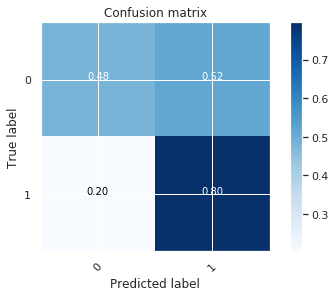

In [56]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred_kmeans),[0,1], normalize = True)

7- (*) Cual es el número óptimo de clusters? (Ver método de ​ Elbow​ con KMeans)


In [ ]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt


# create new plot and data
plt.plot()
X = df_clean[['sender_zipcode', 'receiver_zipcode', 'service']]
colors = ['b', 'g', 'r']
markers = ['o', 'v', 's']

# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


Este metodo me dice que a partir de 5 clusters las distancias no tienen un cambio significativo por lo tanto el numero optimo de clusters podemos tomarlo como 5

8- Describir brevemente las características interesantes de los clusters


Algunas de las caracteristicas interesantes son que:
* Para entrenar no es necesario decir a que etiqueta corresponde cada fila esto se debe a que es un algoritmo de aprendizaje no supervisado
* A pesar de que queremos separar en dos clusters el metodo elbow nos dice que seria mas optimo dividir en 5 clusters

#### Modelos lineales:
9- Leer sobre accuracy, precision y recall para agregarlas al pool de métricas que vamos a utilizar.


Preprocessing de los datos para entrenar con el metodo lineal

In [58]:
df_clean['clasif_velocity']= df_clean.target<=3

In [59]:
df_clean.clasif_velocity

0          True
1         False
2         False
3          True
4         False
5         False
6         False
7         False
8          True
9         False
10        False
11         True
12         True
13         True
14         True
15        False
16        False
17        False
18         True
19         True
20        False
21        False
22        False
23         True
24         True
25         True
26         True
27         True
28        False
29         True
          ...  
999969    False
999970     True
999971    False
999972    False
999973     True
999974    False
999975    False
999976    False
999978    False
999979    False
999980    False
999981    False
999982     True
999983    False
999984    False
999985    False
999986    False
999987     True
999988    False
999989     True
999990     True
999991    False
999992     True
999993    False
999994    False
999995    False
999996    False
999997     True
999998     True
999999    False
Name: clasif_velocity, L

In [60]:
df_clean.clasif_velocity= df_clean.clasif_velocity*1

In [61]:
df_clean.dtypes

sender_state        object
sender_zipcode       int64
receiver_state      object
receiver_zipcode     int64
shipment_type       object
quantity             int64
service              int64
status              object
date_created        object
date_sent           object
date_visit          object
target               int64
clasif_velocity      int64
dtype: object

In [62]:
df_clean=pd.get_dummies(df_clean, columns=['sender_state', 'receiver_state', 'shipment_type'])

In [63]:
from sklearn.model_selection import train_test_split


X = df_clean.drop(['target', 'clasif_velocity', 'date_created', 'date_sent', 'date_visit','status'], axis=1)
y = df_clean['clasif_velocity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [64]:
X.head()

,sender_zipcode,receiver_zipcode,quantity,service,sender_state_AC,sender_state_AL,sender_state_AM,sender_state_AP,sender_state_BA,sender_state_CE,...,receiver_state_RO,receiver_state_RR,receiver_state_RS,receiver_state_SC,receiver_state_SE,receiver_state_SP,receiver_state_TO,shipment_type_express,shipment_type_standard,shipment_type_super
0,3005,5409,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1,17052,37750,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,2033,11040,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
3,13900,18500,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
4,4361,96810,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0


10- Implementar un modelo basado en regresión lineal, calcular las métricas y la matriz de confusión


In [65]:
from sklearn.linear_model import LinearRegression

In [66]:
linear_reg = LinearRegression().fit(X_train, y_train)

In [67]:
y_pred_lin = linear_reg.predict(X_test)

In [68]:
y_pred_lin = (y_pred_lin>0.5)*1


In [69]:
accuracy_score(y_test, y_pred_lin)

0.8594464695012975

In [70]:
recall_score(y_test, y_pred_lin)  

0.8154648563622816

In [71]:
precision_score(y_test, y_pred_lin)  

0.8492738985305529

### el metodo parece andar bien

In [72]:
from sklearn.metrics import confusion_matrix

In [73]:
confusion_matrix(y_test, y_pred_lin)

array([[101284,  12237],
       [ 15603,  68950]])

Normalized confusion matrix
[[0.89220497 0.10779503]
 [0.18453514 0.81546486]]


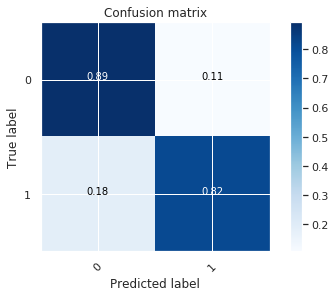

In [75]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred_lin),[0,1], normalize = True)

11- Implementar un modelo basado en regresión logística, calcular las métricas y la matriz de confusión


In [76]:
from sklearn.linear_model import LogisticRegression


In [77]:
clf = LogisticRegression(penalty= 'l1', random_state=0).fit(X_train, y_train)

/home/isanti/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [78]:
y_pred = clf.predict(X_test)

In [79]:
from sklearn.metrics import accuracy_score


In [80]:
accuracy_score(y_test, y_pred)

0.8617688338701698

In [81]:
from sklearn.metrics import recall_score
recall_score(y_test, y_pred)  

0.8091138102728466

In [82]:
from sklearn.metrics import precision_score
precision_score(y_test, y_pred, average='binary')  

0.8588879263806762

Todas las metricas se encuentran por encima del 0.80 lo que podria interpretarse como que el modelo es bueno

In [83]:
confusion_matrix(y_test, y_pred)

array([[102281,  11240],
       [ 16140,  68413]])

Normalized confusion matrix
[[0.90098748 0.09901252]
 [0.19088619 0.80911381]]


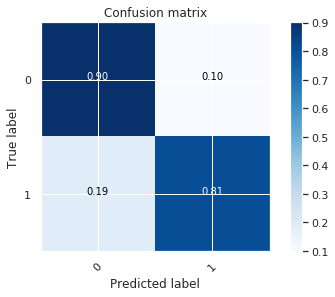

In [84]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred),[0,1], normalize = True)

12- Cual es la principal diferencia entre estos modelos? Tuviste que hacer algún tipo de post-procesamiento?


La principal diferencia entre los modelos es que la Regresión Lineal busca una recta que este lo mas cerca posible de todos los puntos y la Regresion Logística busca una recta que separe los datos en dos grupos.
Al usar la regresion lineal la predicción es una variable continua y tuvimos que elegir un criterio para transformarla en una discreta y poder usar eso como una clasificación.

13- Estandarizar los features seleccionados y re entrenar los modelos. Las métricas
mejoran? Explicar por qué.


In [85]:
from sklearn.preprocessing import MinMaxScaler

In [86]:
scaler = MinMaxScaler()
scaler.fit(df_clean.drop(['target', 'clasif_velocity', 'date_created', 'date_sent', 'date_visit','status'], axis =1))
df_n = scaler.transform(df_clean.drop(['target', 'clasif_velocity', 'date_created', 'date_sent', 'date_visit','status'], axis=1))

/home/isanti/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Ahora reentrenamos con los datos normalizados

In [87]:
X = df_n.copy()
y = df_clean['clasif_velocity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [88]:
from sklearn.linear_model import LinearRegression

In [89]:
linear_reg = LinearRegression().fit(X_train, y_train)

In [90]:
y_pred_lin = linear_reg.predict(X_test)

In [91]:
y_pred_lin = (y_pred_lin>0.5)*1


In [92]:
accuracy_score(y_test, y_pred_lin)

0.8594464695012975

In [93]:
from sklearn.metrics import recall_score
recall_score(y_test, y_pred_lin)  

0.8154648563622816

In [94]:
from sklearn.metrics import precision_score
precision_score(y_test, y_pred_lin)  

0.8492738985305529

In [95]:
from sklearn.metrics import confusion_matrix

In [96]:
confusion_matrix(y_test, y_pred_lin)

array([[101284,  12237],
       [ 15603,  68950]])

Normalized confusion matrix
[[0.89220497 0.10779503]
 [0.18453514 0.81546486]]


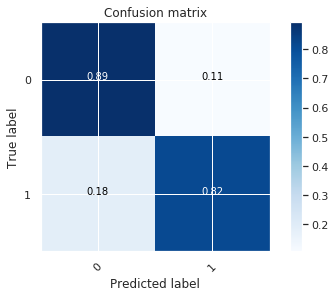

In [97]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred_lin),[0,1], normalize = True)

El metodo lineal con las features normalizadas no presenta un cambio en las metricas

Implemento un modelo basado en regresión logística, calculo las métricas y la matriz de confusión


In [98]:
from sklearn.linear_model import LogisticRegression


In [99]:
clf = LogisticRegression(penalty= 'l1', random_state=0).fit(X_train, y_train)

/home/isanti/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [100]:
y_pred = clf.predict(X_test)

In [101]:
from sklearn.metrics import accuracy_score


In [102]:
accuracy_score(y_test, y_pred)

0.8617637852519765

In [103]:
from sklearn.metrics import recall_score
recall_score(y_test, y_pred)  

0.8091138102728466

In [104]:
from sklearn.metrics import precision_score
precision_score(y_test, y_pred, average='binary')  

0.8588771436462701

En este caso también observamos que no cambiaron, esto se podria deber a que todos los features tenian el mismo peso o que el modelo no es afectado por el rango de los features

In [105]:
confusion_matrix(y_test, y_pred)

array([[102280,  11241],
       [ 16140,  68413]])

Normalized confusion matrix
[[0.90097867 0.09902133]
 [0.19088619 0.80911381]]


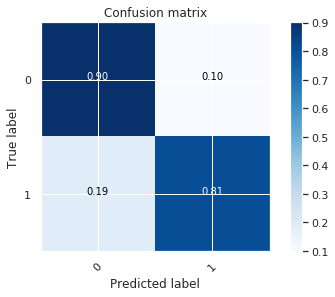

In [106]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred),[0,1], normalize = True)

Para concluir podemos decir que el mejor metodo para clasificarlos fue LogisticRegression. En el kmeans solo usamos las rutas y las metricas nos dieron alrededor de 0.65, esto nos dice que la ruta influye mucho en el tiempo que tarda en llegar un paquete sin embargo en las regresiones usamos ademas otros features y nos dieron mejores metricas lo que podriamos interpretar como que quizas el kmeans andaria mejor con mas features